In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import pandas as pd
import magic as magic
import scprep
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


sys.path.append(os.getcwd())

In [14]:
x = np.transpose(np.load('../SERGIO/imputation_data/DS6_clean.npy'))
y = np.transpose(np.load('../SERGIO/imputation_data/DS6_45.npy'))
print(x.shape, y.shape)

(2700, 1200) (2700, 1200)


In [53]:
x = np.transpose(np.load('../previous_imputations/DS6_clean.npy'))
y = np.transpose(np.load('../previous_imputations/DS6_45.npy'))
print(x.shape, y.shape)

(2700, 1200) (2700, 1200)


From SERGIO Paper: Prior to running MAGIC, we filtered the synthetic data for rare genes (those expressed in less
than 5 cells), and performed library size normalization as well as a square root transformation. We used MAGIC with the parameter t =
2, t = 7, and default setting where t is inferred from data

#### Filter for rare genes (expressed in < 5 cells)

In [9]:
#scprep.plot.plot_library_size(x, cutoff=5000, log=True)
y_hat = scprep.filter.filter_rare_genes(y, min_cells=5)
#scprep.plot.plot_library_size(x_hat, cutoff=5000, log=True)

#### Library size normalization and square root transformation

In [10]:
y_norm = scprep.normalize.library_size_normalize(y_hat)
y_norm = scprep.transform.sqrt(y_norm)
y_norm.shape

(2700, 1195)

#### Run MAGIC

In [11]:
def run_MAGIC(t_val):
    magic_op = magic.MAGIC(
        # knn=5,
        # knn_max=None,
        # decay=1,
        # Variable changed in paper
        t=t_val,
        # n_pca=100,
        # solver="exact",
        # knn_dist="euclidean",
        # n_jobs=1,
        # random_state=None,
        # verbose=1,
    )

    y_hat = magic_op.fit_transform(y_norm, genes='all_genes')
    y_hat.shape

    save_str = 'yhat_MAGIC_t_' + str(t_val)
    np.save(save_str, y_hat)

In [12]:
for t in [2, 7, 'auto']:
    run_MAGIC(t)

Calculating MAGIC...
  Running MAGIC on 2700 cells and 1195 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.76 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.55 seconds.
    Calculating affinities...
    Calculated affinities in 0.63 seconds.
  Calculated graph and diffusion operator in 8.95 seconds.
  Calculating imputation...
  Calculated imputation in 0.07 seconds.
Calculated MAGIC in 9.03 seconds.
Calculating MAGIC...
  Running MAGIC on 2700 cells and 1195 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.06 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.53 seconds.
    Calculating affinities...
    Calculated affinities in 0.45 seconds.
  Calculated graph and diffusion operator in 9.06 seconds.
  Calculating imputation...
  Calculated imputation in 0.20 seconds.
Calculated MAGIC in 9.26 seconds.
Calculating MAGIC...
  Running MAGIC on 

In [3]:
# Load MAGIC imputed data
y_hat_magic_t2 = np.load('../MAGIC/yhat_MAGIC_t_2.npy')
y_hat_magic_t7 = np.load('../MAGIC/yhat_MAGIC_t_7.npy')
y_hat_magic_t_auto = np.load('../MAGIC/yhat_MAGIC_t_auto.npy')

In [49]:
x_corr = pd.DataFrame(x).corr()
y_corr = pd.DataFrame(y).corr()

In [4]:
t2_corr = pd.DataFrame(y_hat_magic_t2).corr()
t7_corr = pd.DataFrame(y_hat_magic_t7).corr()
t_auto_corr = pd.DataFrame(y_hat_magic_t_auto).corr()

In [96]:
def create_true_graph(target_file):
    # Create numpy array of same size as imputation_dataset
    gt_temp = np.zeros((1200, 1200))
    f = open(target_file,'r')
    Lines = f.readlines()
    f.close()
    # For each real gene and measured gene expressions, set new array at coordinates to 1
    for j in range(len(Lines)):#tqdm(range(len(Lines))):
        line = Lines[j]
        line_list = line.split(',')
        target_index = int(float(line_list[0]))
        num_regs = int(float(line_list[1]))
        # skip if gene is not present in filtered dataset
        # if target_index >= gt_temp.shape[1]:
        #     for i in range(0, target_index + 1 - gt_temp.shape[1]):
        #         new_column = np.zeros((gt_temp.shape[0], 1), dtype=int)
        #         gt_temp = np.append(gt_temp, new_column, axis=1)
        #         virtual_imputation = np.append(virtual_imputation, new_column, axis=1)
        for i in range(num_regs):
            reg_index = int(float(line_list[i+2]))
            gt_temp[reg_index,target_index] = 1  
    return gt_temp#, virtual_imputation

In [107]:
target_file = '../SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt'
true = pd.DataFrame(create_true_graph(target_file)).corr().fillna(0)

Text(0.5, 0, 'Corr Coeff')

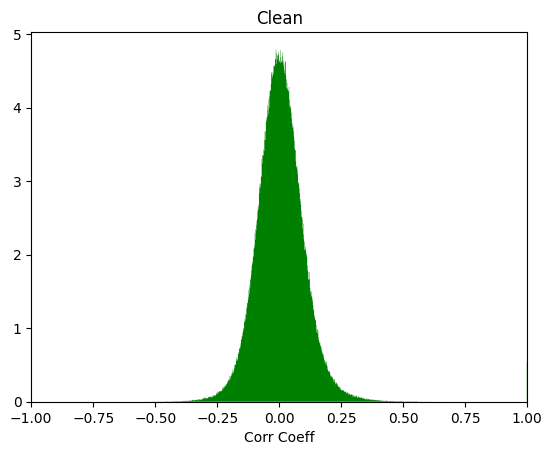

In [111]:
plt.stairs(*np.histogram(x_corr, bins = 1000, density=True), fill=True, color="green")
plt.xlim(-1, 1)
plt.title("Clean")
plt.xlabel("Corr Coeff")

Text(0.5, 0, 'Corr Coeff')

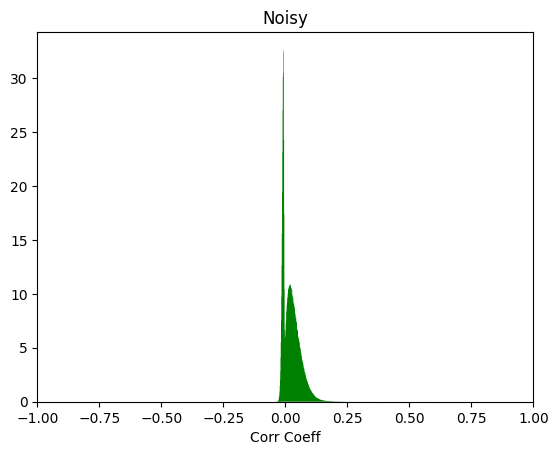

In [60]:
plt.stairs(*np.histogram(y_corr, bins = 1000, density=True), fill=True, color="green")
plt.xlim(-1, 1)
plt.title("Nois")
plt.xlabel("Corr Coeff")

Text(0.5, 0, 'Corr Coeff')

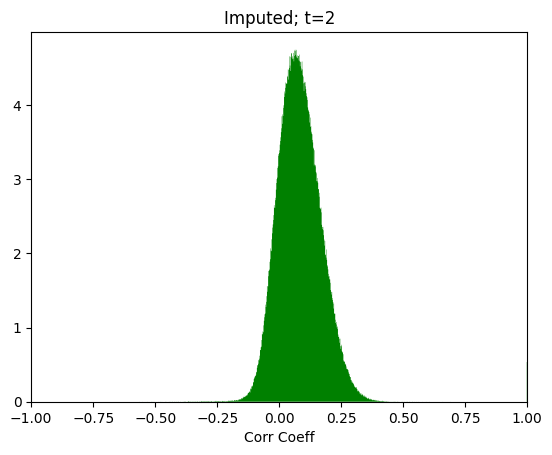

In [112]:
plt.stairs(*np.histogram(t2_corr, bins = 1000, density=True), fill=True, color="green")
plt.xlim(-1, 1)
plt.title("Imputed; t=2")
plt.xlabel("Corr Coeff")

Text(0.5, 0, 'Corr Coeff')

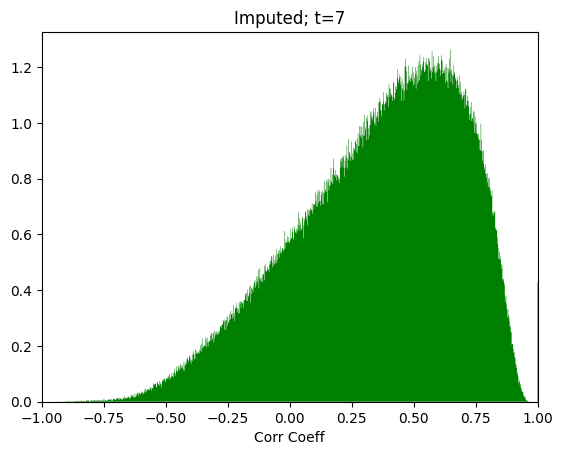

In [64]:
plt.stairs(*np.histogram(t7_corr, bins = 1000, density=True), fill=True, color="green")
plt.xlim(-1, 1)
plt.title("Imputed; t=7")
plt.xlabel("Corr Coeff")

Text(0.5, 0, 'Corr Coeff')

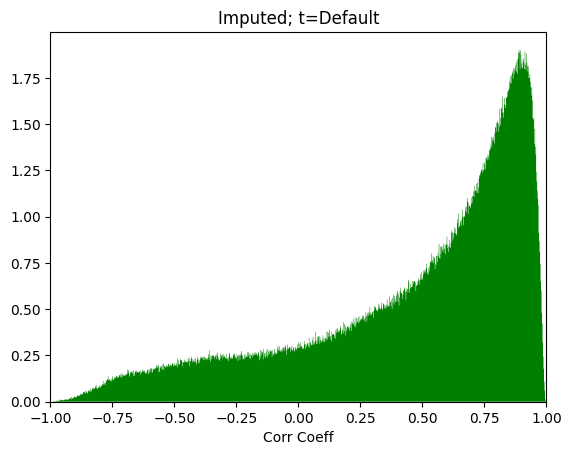

In [70]:
plt.stairs(*np.histogram(t_auto_corr, bins = 1000, density=True), fill=True, color="green")
plt.xlim(-1, 1)
plt.title("Imputed; t=Default")
plt.xlabel("Corr Coeff")